### Accuracy comparison (error)
Relative to brute force, which is better: SGD or epsilon net?

In [34]:
from itertools import combinations

import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import time
import matplotlib.pyplot as plt
import seaborn as sns

from metrics import tpr, fpr, f1, precision, npv, accuracy, selection_rate
from metrics import tpr_torch, fpr_torch, precision_torch, npv_torch, accuracy_torch, f1_torch, selection_rate_torch
from pipeline import tpr_score, fpr_score, npv_score, selection_rate_score

from approx_thresh_light import ApproxThresholdNet, ApproxThresholdGeneral
from approx_thresh_pytorch_light import ApproxThresholdPytorch

In [35]:
xgb_config = {
    'n_estimators': [100, 400, 800],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
}

dataset_name = 'Synthetic'
sensitive_attribute_name = 'A'
classifiers = {'xgb': xgb.XGBClassifier()}
classifier_config_path = 'configs/classifier_config.yml'
lambda_list = [0.1, 1.0, 3.0, 5.0, 7.5, 10.0, 20.0]
n_classes = 2
n_features = 15
group_sizes = [500, 500, 500, 500, 500]
class_separation_scores = [0.5, 0.5, 0.5, 0.5, 0.5]
assert len(group_sizes) == len(class_separation_scores)

FIGSIZE_ONE_COLUMN = (10, 6)
DPI = 120
TITLE_FONTSIZE = 14
LABEL_FONTSIZE = 12
TICKS_FONTSIZE = 10
SUPER_TITLE_FONTSIZE = 16
LINE_WIDTH = 3
MARKER_1 = 'o'
PLOT_STYLE = "whitegrid"

sns.set(style=PLOT_STYLE)
plt.rcParams.update({'figure.figsize': FIGSIZE_ONE_COLUMN, 'figure.dpi': DPI,
                     'axes.titlesize': TITLE_FONTSIZE, 'axes.labelsize': LABEL_FONTSIZE,
                     'xtick.labelsize': TICKS_FONTSIZE, 'ytick.labelsize': TICKS_FONTSIZE,
                     'lines.linewidth': LINE_WIDTH, 'lines.markersize': LINE_WIDTH * 2})

name_map = {
    'ApproxThreshGeneral': 'general',
    'ApproxThreshNet': 'net',
    'ApproxThreshPytorch': 'torch'
}

torch_metric_functions = {
    'tpr': tpr_torch,
    'fpr': fpr_torch,
    'precision': precision_torch,
    'npv': npv_torch,
    'selection_rate': selection_rate_torch
}

metric_functions = {
    'tpr': tpr,
    'fpr': fpr,
    'precision': precision,
    'npv': npv,
    'selection_rate': selection_rate
}

global_metrics_map = {
    'f1': f1,
    'precision': precision,
    'npv': npv,
    'accuracy': accuracy,
}

torch_global_metrics_map = {
    'f1': f1_torch,
    'precision': precision_torch,
    'npv': npv_torch,
    'accuracy': accuracy_torch,
}

metrics = {
    'tpr': tpr_score,
    'fpr': fpr_score,
    'precision': precision_score,
    'recall': recall_score,
    'npv': npv_score,
    'accuracy': accuracy_score,
    'f1': f1_score,
    'selection_rate': selection_rate_score
}

total_samples_range = [100, 200] # , 300, 400, 500, 600, 700, 800, 900, 1000
num_groups_list = [2] 
approaches = [ApproxThresholdGeneral, ApproxThresholdNet, ApproxThresholdPytorch]
approach_names = ['ApproxThreshGeneral', 'ApproxThreshNet', 'ApproxThreshPytorch']

def difficult_classification(total_samples, num_groups, n_features=10, random_state=42, convex_like=False, poly_degree=4):
    if convex_like:
        n_features = 10
        class_sep = 1.0  # higher separation
        n_informative = int(n_features * 0.8)  # more informative features
        n_redundant = int(n_features * 0.1)
        n_repeated = int(n_features * 0.1)
        n_clusters_per_class = 1  # single cluster per class
    else:
        n_features = 10
        class_sep = 0.3
        n_informative = int(n_features * 0.6)
        n_redundant = int(n_features * 0.3)
        n_repeated = int(n_features * 0.1)
        n_clusters_per_class = 7

    X, y = make_classification(
        n_samples=total_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_repeated=n_repeated,
        n_classes=2,
        n_clusters_per_class=n_clusters_per_class,
        class_sep=class_sep,
        weights=[0.5, 0.5] if convex_like else [0.7, 0.3],
        flip_y=0.05 if convex_like else 0.1,
        random_state=random_state
    )
    
    # non-linear transformations for non convex
    if not convex_like:
        poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
        X = poly.fit_transform(X)
    
    n_samples_per_group = total_samples // num_groups
    remainder = total_samples % num_groups
    samples_per_group = [n_samples_per_group + (1 if i < remainder else 0) for i in range(num_groups)]
    A = np.concatenate([np.full(samples_per_group[i], i) for i in range(num_groups)])
    
    return X, y, A



In [ ]:
def run_experiment(y_train_probs, y_train_true, A_train, approach, total_samples, num_groups, name):
    type_approx = name_map[name]
    m_f = metric_functions if type_approx != 'torch' else torch_metric_functions
    if type_approx == 'torch':
        approx = approach(metric_functions=m_f, 
                          global_metric=torch_global_metrics_map['f1'])
    elif type_approx == 'net':
        approx = approach(metric_functions=m_f, 
                          global_metric=global_metrics_map['f1'], 
                          max_error=0.01, 
                          max_total_combinations=total_samples*num_groups)
    else:
        approx = approach(metric_functions=m_f, 
                          global_metric=global_metrics_map['f1'])
    
    approx.fit(y_train_probs, y=y_train_true, A=A_train)
    
    return approx.best_objective_value

results = {
    True: {name: [] for name in approach_names}, 
    False: {name: [] for name in approach_names}
}

iterations = 10

iteration_values_all = {convex_like: {name: [] for name in approach_names} for convex_like in [True, False]}
for convex_like in [True, False]:
    for total_samples in total_samples_range:
        iteration_values = {name: [] for name in approach_names}

        for r_s in range(iterations):
            X, y, A = difficult_classification(total_samples, num_groups_list[0], n_features, random_state=r_s, convex_like=convex_like)
            X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, A, test_size=0.3, random_state=r_s)
            random_search = RandomizedSearchCV(xgb.XGBClassifier(), param_distributions=xgb_config, n_iter=10, cv=2, verbose=0, random_state=r_s, n_jobs=-1)
            random_search.fit(X_train, y_train)
            best_clf = random_search.best_estimator_
            y_train_probs = best_clf.predict_proba(X_train)[:, 1]
            y_train_true = y_train

            for approach, name in zip(approaches, approach_names):
                best_objective_value = run_experiment(y_train_probs, y_train_true, A_train, approach, total_samples, num_groups_list[0], name)
                iteration_values[name].append(best_objective_value)

        for name in approach_names:
            general_values = iteration_values['ApproxThreshGeneral']
            specific_values = iteration_values[name]
            diffs = [abs(specific - general) for specific, general in zip(specific_values, general_values)]
            mean_diff = np.mean(diffs)
            std_diff = np.std(diffs)
            results[convex_like][name].append((total_samples, mean_diff, std_diff))
            # store iteration values
            iteration_values_all[convex_like][name].append(iteration_values[name])

In [7]:
# save iteration_values_all in pickle
with open('iteration_values_all.pickle', 'wb') as handle:
    pickle.dump(iteration_values_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
# load iteration values
with open('iteration_values_all.pickle', 'rb') as handle:
    iteration_values_all = pickle.load(handle)

# load results
with open('results_error_dict.pkl', 'rb') as handle:
    results = pickle.load(handle)

/var/folders/qj/gh_j11514m37mqtfrlr885k40000gn/T/ipykernel_76137/3857889825.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)
/var/folders/qj/gh_j11514m37mqtfrlr885k40000gn/T/ipykernel_76137/3857889825.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


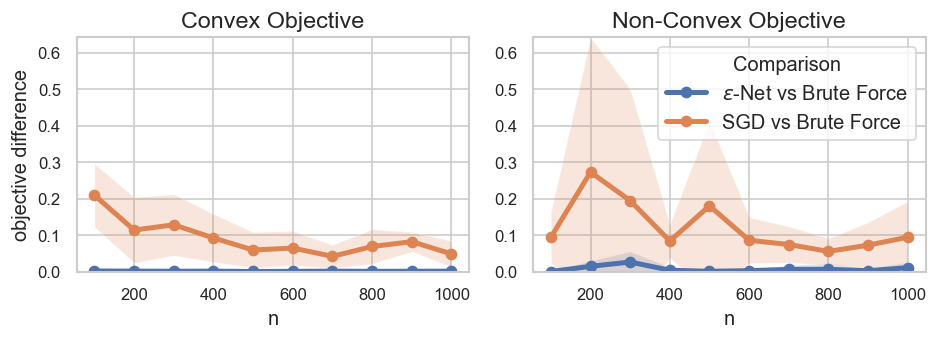

In [58]:

fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=120)
convexity_labels = {True: "Convex Objective", False: "Non-Convex Objective"}

global_min, global_max = float('inf'), float('-inf')
for convex_like in [True, False]:
    for name, data in results[convex_like].items():
        if name == 'ApproxThreshGeneral': continue
        _, means, stds = zip(*data)
        local_min = min(means) - max(stds) 
        local_max = max(means) + max(stds) 
        global_min = min(global_min, local_min)
        global_max = max(global_max, local_max)

for idx, convex_like in enumerate([True, False]):
    ax = axes[idx]
    ax.set_title(f'{convexity_labels[convex_like]}', fontsize=14)
    ax.set_xlabel('Total Number of Samples', fontsize=12)
    ax.set_ylabel('Objective Difference', fontsize=12)
    # ax.set_yscale('symlog')

    for name, data in results[convex_like].items():
        if name == 'ApproxThreshGeneral':
            continue 
        total_samples, means, stds = zip(*data)
        total_samples = np.array(total_samples)
        means = np.array(means)
        stds = np.array(stds)
        
        # Main line plot
        ax.plot(total_samples, means, label=name.split('ApproxThresh')[1], marker='o')
        
        # Translucent color band as error band
        ax.fill_between(total_samples, means - stds, means + stds, alpha=0.2)

    ax.legend(title='Comparison', fontsize=LABEL_FONTSIZE)
    # rename legend labels
    ax.set_xlabel('n', fontsize=LABEL_FONTSIZE)
    ax.set_ylabel('objective difference', fontsize=LABEL_FONTSIZE)
    # ax.set_yscale('symlog')
    ax.set_ylim(0, global_max)
    # y_ticks should be human readable
    y_ticks = ax.get_yticks()
    y_ticks = [f'{round(tick,3)}' for tick in y_ticks]
    # add a tick at y=0

    ax.set_yticklabels(y_ticks)
    handles, labels = ax.get_legend_handles_labels()
    labels[0] = '$\\epsilon$-Net vs Brute Force'
    labels[1] = 'SGD vs Brute Force'
    ax.legend(handles, labels, title='Comparison', fontsize=LABEL_FONTSIZE)
    if idx == 0:
        ax.get_legend().remove()
    elif idx == 1:
        ax.set_ylabel('')
    ax.grid(True)
    ax.grid(True)

plt.tight_layout()
# plt.show()
plt.savefig('error_objective.pdf', bbox_inches='tight', dpi=120, format='pdf')



In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from tqdm import tqdm

def visualize_thresholds_objective(y_true, y_prob, A, metric_functions, lambda_=1.0, global_metric=f1, max_epsilon=1.0):
    unique_groups = np.unique(A)
    assert len(unique_groups) == 2, "This visualization supports exactly 2 unique groups."
    
    threshold_grid = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(threshold_grid, threshold_grid)
    Z = np.zeros(X.shape)
    
    for i in tqdm(range(X.shape[0]), desc="Evaluating grid"):
        for j in range(X.shape[1]):
            thresholds = {unique_groups[0]: X[i, j], unique_groups[1]: Y[i, j]}
            Z[i, j] = compute_objective_for_thresholds(y_true, y_prob, A, unique_groups, thresholds, metric_functions, lambda_, global_metric, max_epsilon)
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    
    ax.set_xlabel('Threshold Group 1')
    ax.set_ylabel('Threshold Group 2')
    ax.set_zlabel('Objective Value')
    ax.set_title('Objective Value Landscape (Convex)')
    # plt.show()
    # save as pdf
    plt.savefig('objective_landscape_convex.pdf', bbox_inches='tight', dpi=120, format='pdf')

def compute_objective_for_thresholds(y_true, y_prob, A, unique_groups, thresholds, metric_functions, lambda_, global_metric, max_epsilon):
    objective = 0
    weighted_acc = 0
    total_size = 0
    
    temp_group_metrics = {}
    for group in unique_groups:
        mask_group = A == group
        temp_group_metrics[group] = _compute_metrics(y_true[mask_group], y_prob[mask_group], thresholds[group], metric_functions)
        
        group_acc = global_metric(y_true[mask_group], np.where(y_prob[mask_group] > thresholds[group], 1, 0))
        group_size = len(y_true[mask_group])
        weighted_acc += group_acc * group_size
        total_size += group_size

    weighted_acc /= total_size
    
    for group in unique_groups:
        group_metric_vector = np.array([temp_group_metrics[group][metric_name] for metric_name in metric_functions.keys()])
        for other_group in unique_groups:
            if group != other_group:
                other_group_metric_vector = np.array([temp_group_metrics[other_group][metric_name] for metric_name in metric_functions.keys()])
                distances = cdist(group_metric_vector.reshape(1, -1), other_group_metric_vector.reshape(1, -1), metric='euclidean')
                objective += np.sum(distances)

    objective += lambda_ * (1 - weighted_acc)
    return objective

def _compute_metrics(y_true, y_prob, threshold, metric_functions):
    y_pred = np.where(y_prob > threshold, 1, 0)
    metrics = {}
    for metric_name, metric_func in metric_functions.items():
        metrics[metric_name] = metric_func(y_true, y_pred)
    return metrics


Evaluating grid: 100%|██████████| 100/100 [00:02<00:00, 39.93it/s]


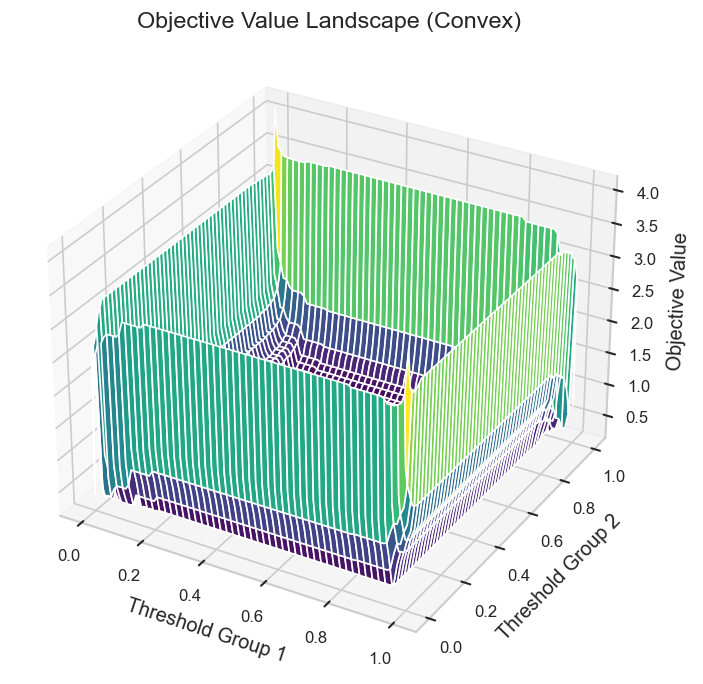

In [55]:
X, y, A = difficult_classification(200, num_groups_list[0], 20, random_state=32, convex_like=True, poly_degree=5)
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, A, test_size=0.3, random_state=r_s)
random_search = RandomizedSearchCV(xgb.XGBClassifier(), param_distributions=xgb_config, n_iter=10, cv=2, verbose=0, random_state=r_s, n_jobs=-1)
random_search.fit(X_train, y_train)
best_clf = random_search.best_estimator_
y_train_probs = best_clf.predict_proba(X_train)[:, 1]
y_train_true = y_train
visualize_thresholds_objective(y_train_true, y_train_probs, A_train, metric_functions, lambda_=0.5, global_metric=f1, max_epsilon=1.0)